## Imports

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image, ImageFont

## Hopfield Network
Fully vectorized operations
Activation can be tanh or sign

In [2]:
class Hopfield:
  def __init__(self, N):
    self.N = N
    self.P = 0
    self.W = np.zeros((N, N), dtype=np.int32)

  def linear_activation(self, a):
    u = np.dot(a, self.W)
    return u

  @staticmethod
  def sign_activation(u):
    a = np.sign(u)
    return a

  @staticmethod
  def tanh_activation(u):
    a = np.tanh(u)
    return a

  def activation(self, u, activation):
    if activation == 'tanh':
      return self.tanh_activation(u)
    return self.sign_activation(u)

  def compute_weights(self, patterns):
    temp = np.dot(patterns.T, patterns)
    np.fill_diagonal(temp, 0.0)
    self.W = temp

  def compute_diff(self, a0, a):
    temp = np.equal(a0, a)
    true_count = np.count_nonzero(temp)
    return self.P - true_count

  def compute_accuracy(self, diff_count):
    return (self.P - diff_count) / self.P

  def compute_energy(self, a):
    """
      Returns a number
    """
    e =  -1 * np.sum(np.multiply(np.outer(a, a), self.W))
    return e

  @staticmethod
  def converged(a, a_before):
    """
    a shape: (N, )
    if a and a_before are same return True
    """
    return np.array_equal(a, a_before)

  def train(self, X):
    """
    X: patterns vector: numpy array of shape: (K, N)
    K: number of patterns
    N: number of neurons
    """
    self.compute_weights(X)
    self.P = X.shape[1]
    return self.W

  def predict(self, y, epochs, activation):
    """
    Inputs:
      y: test input: an array
    Outputs:
      yp: The best activation across all epochs  (N,)
      acc: Accuracy of returned a Number
      e: Energy of returned a Number
    """
    A = []
    a = np.array(y)
    A.append(a)

    # D shape: (epochs+1, )
    D = [math.inf]

    iterator = tqdm(range(epochs))
    for i in iterator:
      u = self.linear_activation(a)
      a = self.activation(u, activation)
      d = self.compute_diff(y, a)

      A.append(a)
      D.append(d)

      # Early stop
      if self.converged(A[-1], A[-2]):
        iterator.close()
        if i == 0:
          print("Input is already stable.")
        else:
          print("Consecutive same pattern in iteration:", i)
        break

    A = np.array(A)
    D = np.array(D)

    # Find nearest pattern
    index = np.argmin(D)
    yp = A[index]
    print("Nearest pattern found in iteration:", index)

    # Accuracy
    acc = self.compute_accuracy(D[index])

    # Energy
    e = self.compute_energy(yp)

    return yp, acc, e

## Test on a simple pattern

In [3]:
hopfield = Hopfield(4)

X = np.array([
  [1, 1, 1, 1],
  [-1, -1, -1, -1],
  [1, 1, -1, -1],
  [-1, -1, 1, 1]
])

a = [-1, 1, -1, 1]

W = hopfield.train(X)
yp, acc, e = hopfield.predict(a, epochs=5, activation="sign")

print("Weight Matrix:", W)
print("Test pattern:", a)
print("Nearest pattern found:", yp)
print("Accuracy:", acc * 100, "%")
print("Energy:", e)

  0%|          | 0/5 [00:00<?, ?it/s]

Nearest pattern found in iteration: 2
Weight Matrix: [[0 4 0 0]
 [4 0 0 0]
 [0 0 0 4]
 [0 0 4 0]]
Test pattern: [-1, 1, -1, 1]
Nearest pattern found: [-1  1 -1  1]
Accuracy: 100.0 %
Energy: 16


## Image utility functions

In [4]:
def img_to_sgn(image):
  """
  Input: an image file
  Output: 2d array of -1 and +1
  """
  img = image.convert(mode="L")
  img_arr = np.asarray(img, dtype=np.uint8)
  sgn_arr = np.zeros(img_arr.shape, dtype=np.int8)
  sgn_arr[img_arr > (255 / 2)] = 1
  sgn_arr[sgn_arr == 0] = -1
  return sgn_arr

def add_noise(image, percent):
  """
  Input: an image file
  Output: an image file with noise added
  """
  img_arr = np.asarray(image, dtype=np.uint8)
  mean = np.mean(img_arr)
  std = np.std(img_arr)
  rand_arr = np.random.normal(mean, std, img_arr.shape)
  img_arr = img_arr + rand_arr * percent
  img = Image.fromarray(img_arr)
  return img

## My image

### Loading

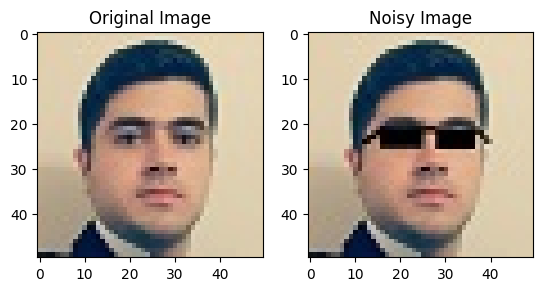

In [5]:
img_me = Image.open('data/me.jpg')
img_noise = Image.open('data/me_noise.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text('Original Image')
ax1.imshow(img_me)

ax2.title.set_text('Noisy Image')
ax2.imshow(img_noise)

### Preprocessing

In [6]:
# shape: (50, 50)
sgn_me = img_to_sgn(img_me)
sgn_noise = img_to_sgn(img_noise)

# shape: (1, 2500)
X = sgn_me.flatten().reshape(1, -1)

# shape: (256,)
a = sgn_noise.flatten()

### Train

In [7]:
hopfield = Hopfield(2500)

hopfield.train(X)
yp, acc, e = hopfield.predict(a, epochs=5, activation="sign")

print("Accuracy:", acc * 100, "%")
print("Energy:", e)

  0%|          | 0/5 [00:00<?, ?it/s]

Nearest pattern found in iteration: 1
Accuracy: 97.76 %
Energy: -6247500


### Results

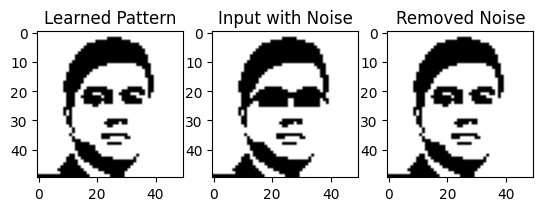

In [8]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.title.set_text('Learned Pattern')
ax1.imshow(X.reshape(50, 50), cmap='gray')

ax2.title.set_text('Input with Noise')
ax2.imshow(a.reshape(50, 50), cmap='gray')

ax3.title.set_text('Removed Noise')
ax3.imshow(yp.reshape(50, 50).astype(int), cmap='gray')

## English letters dataset

### Dataset Creation

In [9]:
def create_dataset(charset, font_size, size, noise):
  font = ImageFont.truetype("data/Arial.ttf", font_size)

  X = []
  Y = []

  for char in charset:
    im = Image.Image()._new(font.getmask(char)).resize((size, size))
    im_noise = add_noise(im, noise)
    sgn_arr = img_to_sgn(im)
    sgn_noise_arr = img_to_sgn(im_noise)
    X.append(sgn_arr.flatten())
    Y.append(sgn_noise_arr.flatten())

  X = np.array(X)
  Y = np.array(Y)

  return X, Y

def plot_result(X, Y, Yp):
  n = X.shape[0]
  size = int(math.sqrt(X.shape[1]))

  fig, axs = plt.subplots(10, 3)

  for i in range(n):
    axs[i, 0].imshow(X[i].reshape(size, size), cmap='gray')
    axs[i, 1].imshow(Y[i].reshape(size, size), cmap='gray')
    axs[i, 2].imshow(Yp[i].reshape(size, size).astype(int), cmap='gray')

### Train and Results

In [10]:
def do_the_job(font_size, noise):
  size = int(font_size * .75)
  X, Y = create_dataset("ABCDEFGHIJ", font_size, size, noise)

  hopfield = Hopfield(size**2)
  hopfield.train(X)

  Yp = []
  accuracies = []
  acc = None
  e = None
  for a in Y:
    yp, acc, e = hopfield.predict(a, epochs=5000, activation="sign")
    Yp.append(yp)
    accuracies.append(acc)

  print("Accuracy:", acc * 100, "%")
  print("Energy:", e)
  print()

  Yp = np.array(Yp)
  accuracies = np.array(accuracies)

  print()
  print("======= Final Result =======")
  print("Font size:", font_size)
  print("Noise:", noise * 100, "%")
  print("Average accuracy:", np.average(accuracies) * 100, "%")
  plot_result(X, Y, Yp)

  0%|          | 0/5000 [00:00<?, ?it/s]

Nearest pattern found in iteration: 128


  0%|          | 0/5000 [00:00<?, ?it/s]

Nearest pattern found in iteration: 1006


  0%|          | 0/5000 [00:00<?, ?it/s]

Nearest pattern found in iteration: 30


  0%|          | 0/5000 [00:00<?, ?it/s]

Nearest pattern found in iteration: 886


  0%|          | 0/5000 [00:00<?, ?it/s]

Nearest pattern found in iteration: 277


  0%|          | 0/5000 [00:00<?, ?it/s]

Nearest pattern found in iteration: 175


  0%|          | 0/5000 [00:00<?, ?it/s]

Nearest pattern found in iteration: 51


  0%|          | 0/5000 [00:00<?, ?it/s]

Nearest pattern found in iteration: 132


  0%|          | 0/5000 [00:00<?, ?it/s]

Nearest pattern found in iteration: 291


  0%|          | 0/5000 [00:00<?, ?it/s]

Nearest pattern found in iteration: 180
Accuracy: 86.80555555555556 %
Energy: -38880


======= Final Result =======
Font size: 16
Noise: 10.0 %
Average accuracy: 89.30555555555554 %


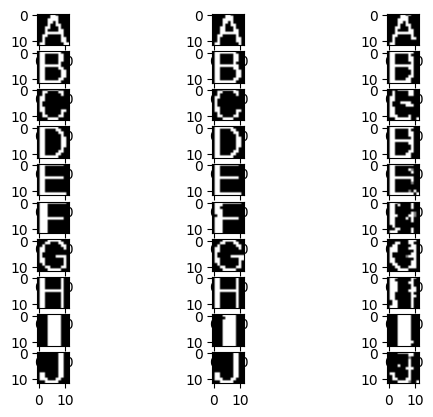

In [11]:
font_size = 16
noise = 0.1
do_the_job(font_size, noise)